In [103]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

In [104]:
df = pd.read_csv('ev_charging_patterns.csv')
df.head(10)

,User ID,Vehicle Model,Battery Capacity (kWh),Charging Station ID,Charging Station Location,Charging Start Time,Charging End Time,Energy Consumed (kWh),Charging Duration (hours),Charging Rate (kW),Charging Cost (USD),Time of Day,Day of Week,State of Charge (Start %),State of Charge (End %),Distance Driven (since last charge) (km),Temperature (°C),Vehicle Age (years),Charger Type,User Type
0,User_1,BMW i3,108.463007,Station_391,Houston,2024-01-01 00:00:00,2024-01-01 00:39:00,60.712346,0.591363,36.389181,13.087717,Evening,Tuesday,29.371576,86.119962,293.602111,27.947953,2.000000,DC Fast Charger,Commuter
1,User_2,Hyundai Kona,100.000000,Station_428,San Francisco,2024-01-01 01:00:00,2024-01-01 03:01:00,12.339275,3.133652,30.677735,21.128448,Morning,Monday,10.115778,84.664344,112.112804,14.311026,3.000000,Level 1,Casual Driver
2,User_3,Chevy Bolt,75.000000,Station_181,San Francisco,2024-01-01 02:00:00,2024-01-01 04:48:00,19.128876,2.452653,27.513593,35.667270,Morning,Thursday,6.854604,69.917615,71.799253,21.002002,2.000000,Level 2,Commuter
3,User_4,Hyundai Kona,50.000000,Station_327,Houston,2024-01-01 03:00:00,2024-01-01 06:42:00,79.457824,1.266431,32.882870,13.036239,Evening,Saturday,83.120003,99.624328,199.577785,38.316313,1.000000,Level 1,Long-Distance Traveler
4,User_5,Hyundai Kona,50.000000,Station_108,Los Angeles,2024-01-01 04:00:00,2024-01-01 05:46:00,19.629104,2.019765,10.215712,10.161471,Morning,Saturday,54.258950,63.743786,203.661847,-7.834199,1.000000,Level 1,Long-Distance Traveler
5,User_6,Nissan Leaf,50.000000,Station_335,San Francisco,2024-01-01 05:00:00,2024-01-01 07:10:00,43.181137,1.167640,14.334523,36.900341,Evening,Saturday,75.217748,71.982288,143.680046,-5.274218,0.000000,DC Fast Charger,Long-Distance Traveler
6,User_7,Chevy Bolt,85.000000,Station_162,Houston,2024-01-01 06:00:00,2024-01-01 07:53:00,36.862140,3.539619,26.185188,22.214225,Evening,Friday,60.751781,70.796097,81.338009,27.551335,4.000000,Level 2,Commuter
7,User_8,Chevy Bolt,75.000000,Station_302,Los Angeles,2024-01-01 07:00:00,2024-01-01 10:42:00,51.467617,2.655396,26.702908,9.796821,Afternoon,Monday,56.201703,63.786815,116.543166,-4.417460,0.000000,Level 2,Long-Distance Traveler
8,User_9,Chevy Bolt,62.000000,Station_493,Los Angeles,2024-01-01 08:00:00,2024-01-01 09:21:00,43.592372,1.724204,14.294923,32.465005,Evening,Wednesday,33.466200,92.961421,208.259742,22.516706,4.000000,Level 1,Commuter
9,User_10,Hyundai Kona,50.000000,Station_452,Chicago,2024-01-01 09:00:00,2024-01-01 12:44:00,78.868607,2.026875,11.761000,21.312302,Morning,Wednesday,27.399455,70.053381,54.006309,27.512019,2.830381,DC Fast Charger,Commuter


In [105]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1320 entries, 0 to 1319
Data columns (total 20 columns):
 #   Column                                    Non-Null Count  Dtype  
---  ------                                    --------------  -----  
 0   User ID                                   1320 non-null   object 
 1   Vehicle Model                             1320 non-null   object 
 2   Battery Capacity (kWh)                    1320 non-null   float64
 3   Charging Station ID                       1320 non-null   object 
 4   Charging Station Location                 1320 non-null   object 
 5   Charging Start Time                       1320 non-null   object 
 6   Charging End Time                         1320 non-null   object 
 7   Energy Consumed (kWh)                     1254 non-null   float64
 8   Charging Duration (hours)                 1320 non-null   float64
 9   Charging Rate (kW)                        1254 non-null   float64
 10  Charging Cost (USD)                 

In [106]:
# 转换为时间变量
df['Charging Start Time'] = pd.to_datetime(df['Charging Start Time'], errors='coerce')
df['Charging End Time'] = pd.to_datetime(df['Charging End Time'], errors='coerce')

# 转化为类型变量减小内存占用(净整没用的
categorical_columns = ['User Type', 'Vehicle Model', 'Charging Station Location', 'Time of Day', 'Day of Week', 'Charger Type']
for column in categorical_columns:
    df[column] = df[column].astype('category')


In [107]:
# 删除含空值的行，重复行
df = df.dropna()
df = df.drop_duplicates()

# 把电越充越少坏东西的删掉
df = df.drop(df[df['State of Charge (End %)'] < df['State of Charge (Start %)']].index)
    
# 把充满了的删掉（因为会影响我们不知道他实际充电时间了（比划
df = df[df['State of Charge (End %)'] <= 99]


In [108]:
# 构造新特征充电持续时间，不知道有啥用先搞了再说
df['Charging Duration_Cate'] = pd.cut(df['Charging Duration (hours)'],
                                          bins=[0, 1, 3, 6, np.inf],
                                          labels=['Short (<1 hr)', 'Medium (1-3 hrs)', 'Long (3-6 hrs)', 'Very Long (>6 hrs)'])

# Display count of different charging duration categories
print(df['Charging Duration_Cate'].value_counts())

df.info()

Medium (1-3 hrs)      488
Long (3-6 hrs)        246
Short (<1 hr)         115
Very Long (>6 hrs)      2
Name: Charging Duration_Cate, dtype: int64
<class 'pandas.core.frame.DataFrame'>
Int64Index: 851 entries, 0 to 1317
Data columns (total 21 columns):
 #   Column                                    Non-Null Count  Dtype         
---  ------                                    --------------  -----         
 0   User ID                                   851 non-null    object        
 1   Vehicle Model                             851 non-null    category      
 2   Battery Capacity (kWh)                    851 non-null    float64       
 3   Charging Station ID                       851 non-null    object        
 4   Charging Station Location                 851 non-null    category      
 5   Charging Start Time                       851 non-null    datetime64[ns]
 6   Charging End Time                         851 non-null    datetime64[ns]
 7   Energy Consumed (kWh)                   

In [109]:
# 用实际数据计算出实际的充电效率Charging Efficiency，啊这个啊很重要很重要要考的啊
df['Charging Efficiency'] = (((df['State of Charge (End %)'] - df['State of Charge (Start %)']) / 100) * df['Battery Capacity (kWh)']) / df['Charging Duration (hours)']

# 与原表中的理论值Charging Rate (kW)作比较
df['Loss'] = df['Charging Rate (kW)'] - df['Charging Efficiency']


In [110]:
# Remove obvious outliers in Charging Efficiency 去除极端的异常值
q1 = df['Charging Efficiency'].quantile(0.25)
q3 = df['Charging Efficiency'].quantile(0.75)
lower_bound = q1 - 1.5 * (q3 - q1)
upper_bound = q3 + 1.5 * (q3 - q1)
df = df[(df['Charging Efficiency'] >= lower_bound) & (df['Charging Efficiency'] <= upper_bound)]

# 把右侧Charging Rate太大的删掉
df = df[df['Charging Rate (kW)'] <= df['Charging Rate (kW)'].quantile(0.95)]

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 760 entries, 1 to 1317
Data columns (total 23 columns):
 #   Column                                    Non-Null Count  Dtype         
---  ------                                    --------------  -----         
 0   User ID                                   760 non-null    object        
 1   Vehicle Model                             760 non-null    category      
 2   Battery Capacity (kWh)                    760 non-null    float64       
 3   Charging Station ID                       760 non-null    object        
 4   Charging Station Location                 760 non-null    category      
 5   Charging Start Time                       760 non-null    datetime64[ns]
 6   Charging End Time                         760 non-null    datetime64[ns]
 7   Energy Consumed (kWh)                     760 non-null    float64       
 8   Charging Duration (hours)                 760 non-null    float64       
 9   Charging Rate (kW)             

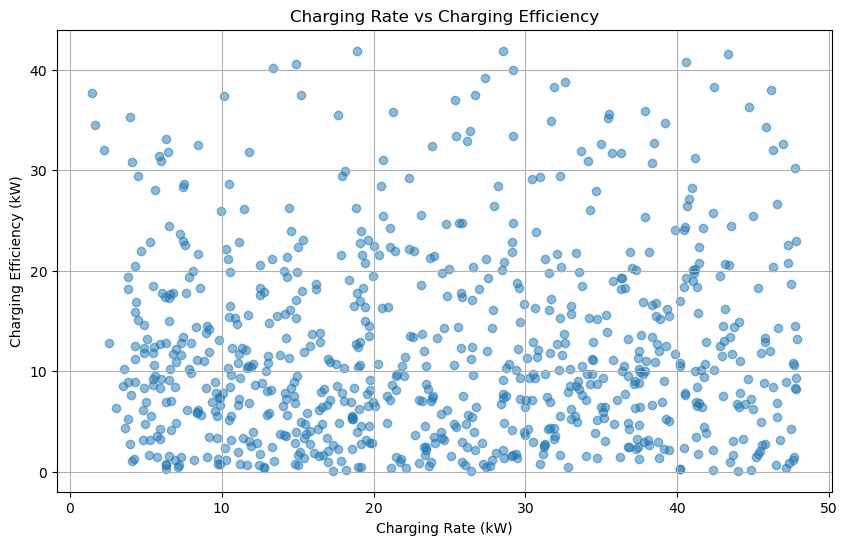

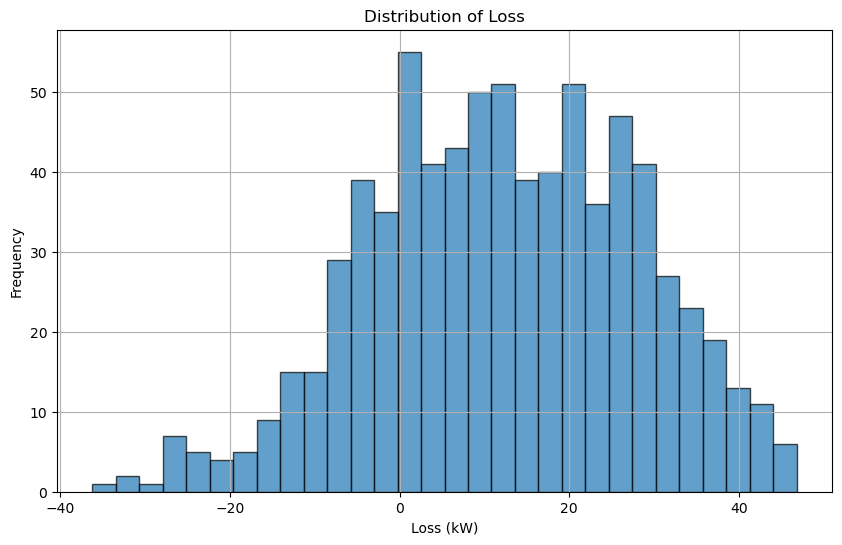

In [111]:
# Visualize Charging Rate vs Charging Efficiency 这个是他们俩的分布散点图
plt.figure(figsize=(10, 6))
plt.scatter(df['Charging Rate (kW)'], df['Charging Efficiency'], alpha=0.5)
plt.xlabel('Charging Rate (kW)')
plt.ylabel('Charging Efficiency (kW)')
plt.title('Charging Rate vs Charging Efficiency')
plt.grid(True)
plt.show()

# Visualize the distribution of Loss 画出loss图（loss是用充电功率-实际充进去的功率算的反正也不知道有没有道理 画了再说
plt.figure(figsize=(10, 6))
plt.hist(df['Loss'], bins=30, edgecolor='black', alpha=0.7)
plt.xlabel('Loss (kW)')
plt.ylabel('Frequency')
plt.title('Distribution of Loss')
plt.grid(True)
plt.show()

# 预处理就到这了，下面都是在乱搞

In [112]:
# 整体分析
features = ['Charging Duration (hours)', 'Time of Day', 'State of Charge (Start %)', 'State of Charge (End %)', 'Temperature (°C)', 'Vehicle Age (years)']
y_efficiency = df['Charging Efficiency']
X = df[features]
X = pd.get_dummies(X, drop_first=True)

X_train, X_test, y_train, y_test = train_test_split(X, y_efficiency, test_size=0.2, random_state=0)



In [113]:
# Linear Regression for Charging Efficiency 针对每小时充电效率的线性回归
from sklearn.model_selection import GridSearchCV
lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)
y_pred_lin = lin_reg.predict(X_test)

print(r2_score(y_test, y_pred_lin))

# Random Forest Regression for Charging Efficiency 针对每小时充电效率的随机森林回归
rf_reg = RandomForestRegressor(random_state=0)
rf_reg.fit(X_train, y_train)
y_pred_rf = rf_reg.predict(X_test)
print(r2_score(y_test, y_pred_rf))

0.6709825775938596
0.7922228139073508


In [114]:
# 我现在想的是目标变量：Charging Efficiency，特征：'Charging Duration (hours)', 'Time of Day'， 'State of Charge (Start %)', 'State of Charge (End %)', 'Temperature (°C)', 'Vehicle Age (years)'
# 先对所有数据整体分析，然后对分类对不同的Vehicle Model，User Type进行分类分析，比较类别之间的差异

In [115]:
df

,User ID,Vehicle Model,Battery Capacity (kWh),Charging Station ID,Charging Station Location,Charging Start Time,Charging End Time,Energy Consumed (kWh),Charging Duration (hours),Charging Rate (kW),...,State of Charge (Start %),State of Charge (End %),Distance Driven (since last charge) (km),Temperature (°C),Vehicle Age (years),Charger Type,User Type,Charging Duration_Cate,Charging Efficiency,Loss
1,User_2,Hyundai Kona,100.000000,Station_428,San Francisco,2024-01-01 01:00:00,2024-01-01 03:01:00,12.339275,3.133652,30.677735,...,10.115778,84.664344,112.112804,14.311026,3.0,Level 1,Casual Driver,Long (3-6 hrs),23.789676,6.888059
2,User_3,Chevy Bolt,75.000000,Station_181,San Francisco,2024-01-01 02:00:00,2024-01-01 04:48:00,19.128876,2.452653,27.513593,...,6.854604,69.917615,71.799253,21.002002,2.0,Level 2,Commuter,Medium (1-3 hrs),19.284124,8.229469
4,User_5,Hyundai Kona,50.000000,Station_108,Los Angeles,2024-01-01 04:00:00,2024-01-01 05:46:00,19.629104,2.019765,10.215712,...,54.258950,63.743786,203.661847,-7.834199,1.0,Level 1,Long-Distance Traveler,Medium (1-3 hrs),2.348005,7.867707
6,User_7,Chevy Bolt,85.000000,Station_162,Houston,2024-01-01 06:00:00,2024-01-01 07:53:00,36.862140,3.539619,26.185188,...,60.751781,70.796097,81.338009,27.551335,4.0,Level 2,Commuter,Long (3-6 hrs),2.412030,23.773157
7,User_8,Chevy Bolt,75.000000,Station_302,Los Angeles,2024-01-01 07:00:00,2024-01-01 10:42:00,51.467617,2.655396,26.702908,...,56.201703,63.786815,116.543166,-4.417460,0.0,Level 2,Long-Distance Traveler,Medium (1-3 hrs),2.142367,24.560541
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1311,User_1312,Hyundai Kona,50.000000,Station_13,Houston,2024-02-24 15:00:00,2024-02-24 18:53:00,74.276701,2.849151,25.073544,...,41.344062,50.412341,194.793544,7.731967,3.0,Level 2,Commuter,Medium (1-3 hrs),1.591400,23.482144
1313,User_1314,Tesla Model 3,129.350616,Station_458,Chicago,2024-02-24 17:00:00,2024-02-24 19:35:00,60.725144,2.365991,10.491921,...,41.856825,94.097883,279.552278,-1.369994,3.0,Level 2,Long-Distance Traveler,Medium (1-3 hrs),28.560605,-18.068684
1315,User_1316,Nissan Leaf,100.000000,Station_57,New York,2024-02-24 19:00:00,2024-02-24 20:30:00,42.011654,1.426444,5.895475,...,39.204102,83.915952,239.601075,1.919655,7.0,DC Fast Charger,Commuter,Medium (1-3 hrs),31.344967,-25.449492
1316,User_1317,BMW i3,100.000000,Station_40,New York,2024-02-24 20:00:00,2024-02-24 20:44:00,68.185853,3.238212,18.388012,...,31.456375,93.096461,164.376022,34.029775,4.0,Level 2,Casual Driver,Long (3-6 hrs),19.035220,-0.647209


In [116]:
def draw_plot_by(cut_column, value_column, target_column, label, start, end, freq, legend_location):
    """
    这个是用来快速画图的方法，用的是分类切割的
    :param cut_column: 这个是你想分组的行
    :param value_column: 这个是随便乱填就能行的行
    :param target_column: 这个是你想分组计算平均值的行
    :param label: 这个是你想用什么作为标签分类的
    :param start: 这个是你想从多少开始分组
    :param end: 这个是你想在多少结束分组
    :param freq: 这个是你想按多少个单位来分组，比如0.5小时就填0.5
    :param legend_location: 这个是你想要图例画在哪个位置
    :return: 没有返回值，略略略
    """

    self_use = df.copy()
    self_use[value_column] = pd.cut(self_use[cut_column], bins=pd.interval_range(start=start, end=end, freq=freq))

    # 按 value_group 和 category 分组计算 other_column 的平均值
    grouped = self_use.groupby([value_column, label])[target_column].mean().reset_index()


    grouped[value_column] = grouped[value_column].apply(lambda x: x.right)

    list = grouped[label].unique()


    color_name = "Paired"
    select = (0, 3, 5, 7, 9)
    color = plt.get_cmap(color_name)(select)

    index = 0
    for type in list:
        resource = grouped[grouped[label]==type]
        Xvalue = resource[value_column].tolist()
        Yvalue = resource[target_column].tolist()
        plt.plot(Xvalue, Yvalue, c=color[index], marker='o', linestyle='-', label=type)
        index+=1
    plt.legend(title=label, loc=legend_location)
    plt.xlabel(cut_column)
    plt.ylabel(target_column)
    plt.title(cut_column + " with " + target_column)
    plt.show()

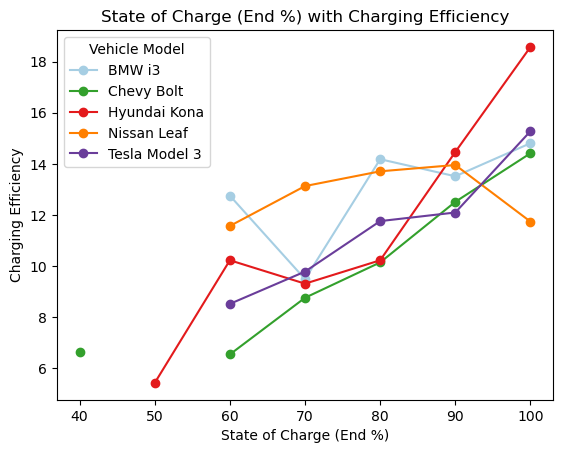

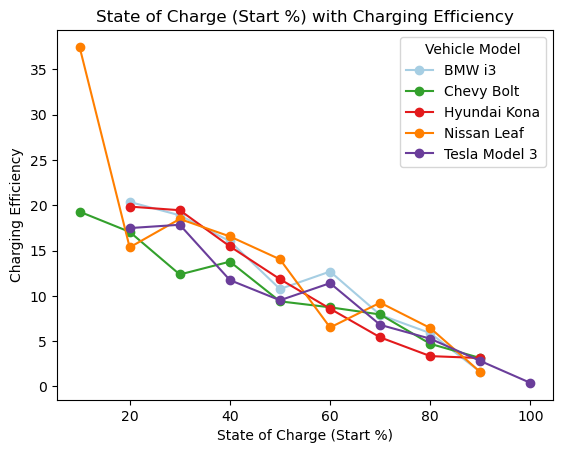

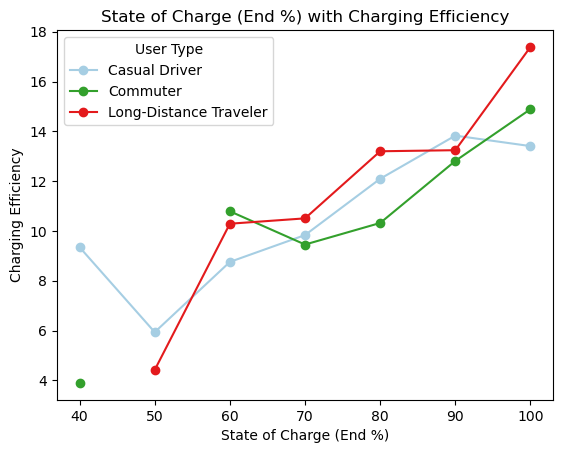

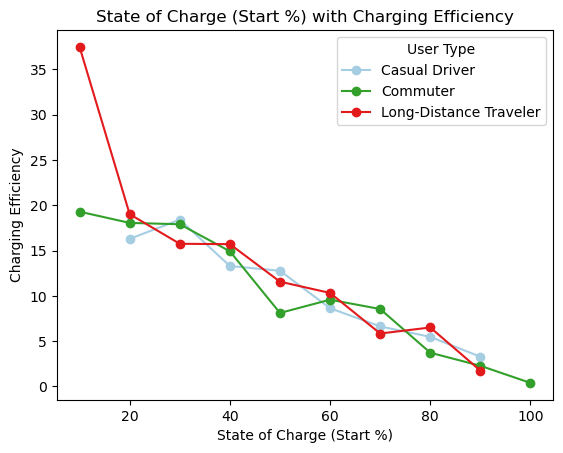

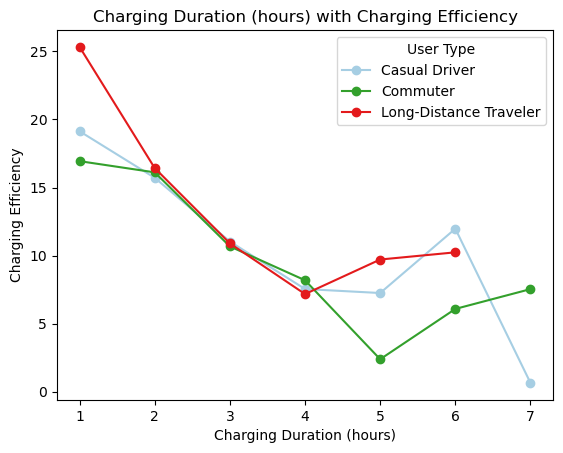

In [117]:
draw_plot_by("State of Charge (End %)", "end charge state with vehicle model", "Charging Efficiency", "Vehicle Model",0, 100, 10, "upper left")
draw_plot_by("State of Charge (Start %)", "end charge state with vehicle model", "Charging Efficiency", "Vehicle Model",0, 100, 10, "upper right")
draw_plot_by("State of Charge (End %)", "end charge state with vehicle model", "Charging Efficiency", "User Type",0, 100, 10, "upper left")
draw_plot_by("State of Charge (Start %)", "end charge state with vehicle model", "Charging Efficiency", "User Type",0, 100, 10, "upper right")

draw_plot_by("Charging Duration (hours)", "charging duration with user type", "Charging Efficiency", "User Type", 0, 8, 1, "upper right")

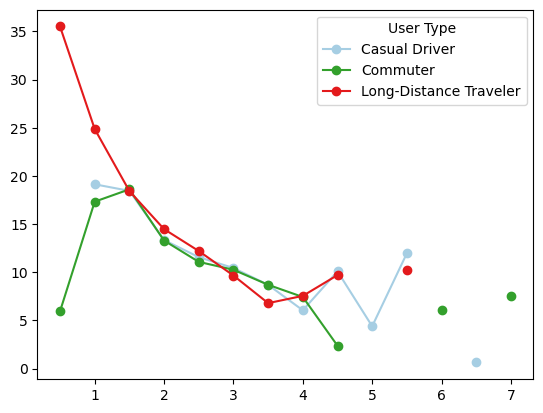

In [118]:
df['charging duration with user type'] = pd.cut(df['Charging Duration (hours)'], bins=pd.interval_range(start=0, end=8, freq=0.5))

# 按 value_group 和 category 分组计算 other_column 的平均值
grouped = df.groupby(['charging duration with user type', "User Type"])['Charging Efficiency'].mean().reset_index()


grouped['charging duration with user type'] = grouped["charging duration with user type"].apply(lambda x: x.right)

list = grouped["User Type"].unique()


color_name = "Paired"
select = (0, 3, 5, 7, 9)
color = plt.get_cmap(color_name)(select)

index = 0
for type in list:
    resource = grouped[grouped["User Type"]==type]
    Xvalue = resource["charging duration with user type"].tolist()
    Yvalue = resource["Charging Efficiency"].tolist()
    plt.plot(Xvalue, Yvalue, c=color[index], marker='o', linestyle='-', label=type)
    index+=1

plt.legend(title="User Type", loc='upper right')
plt.show()

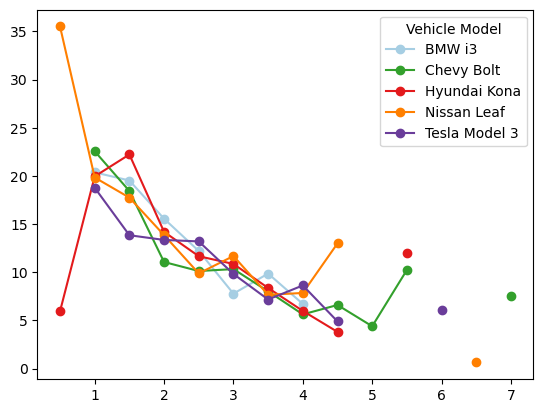

In [119]:
df['charging duration with vehicle model'] = pd.cut(df['Charging Duration (hours)'], bins=pd.interval_range(start=0, end=8, freq=0.5))

# 按 value_group 和 category 分组计算 other_column 的平均值
grouped = df.groupby(['charging duration with vehicle model', "Vehicle Model"])['Charging Efficiency'].mean().reset_index()


grouped['charging duration with vehicle model'] = grouped['charging duration with vehicle model'].apply(lambda x: x.right)

list = grouped["Vehicle Model"].unique()


color_name = "Paired"
select = (0, 3, 5, 7, 9)
color = plt.get_cmap(color_name)(select)

index = 0
for type in list:
    resource = grouped[grouped["Vehicle Model"]==type]
    Xvalue = resource["charging duration with vehicle model"].tolist()
    Yvalue = resource["Charging Efficiency"].tolist()
    plt.plot(Xvalue, Yvalue, c=color[index], marker='o', linestyle='-', label=type)
    index+=1

plt.legend(title="Vehicle Model", loc='upper right')
plt.show()

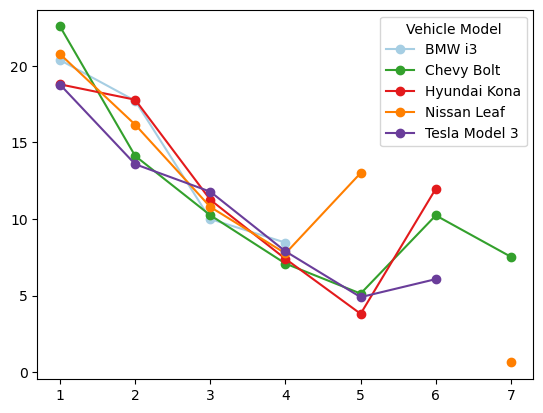

In [120]:
df['charging duration with vehicle model'] = pd.cut(df['Charging Duration (hours)'], bins=pd.interval_range(start=0, end=8, freq=1))

# 按 value_group 和 category 分组计算 other_column 的平均值
grouped = df.groupby(['charging duration with vehicle model', "Vehicle Model"])['Charging Efficiency'].mean().reset_index()


grouped['charging duration with vehicle model'] = grouped['charging duration with vehicle model'].apply(lambda x: x.right)

list = grouped["Vehicle Model"].unique()


color_name = "Paired"
select = (0, 3, 5, 7, 9)
color = plt.get_cmap(color_name)(select)

index = 0
for type in list:
    resource = grouped[grouped["Vehicle Model"]==type]
    Xvalue = resource["charging duration with vehicle model"].tolist()
    Yvalue = resource["Charging Efficiency"].tolist()
    plt.plot(Xvalue, Yvalue, c=color[index], marker='o', linestyle='-', label=type)
    index+=1

plt.legend(title="Vehicle Model", loc='upper right')
plt.show()

# 我现在想的是目标变量：Charging Efficiency，特征：'Charging Duration (hours)', 'Time of Day'， 'State of Charge (Start %)', 'State of Charge (End %)', 'Temperature (°C)', 'Vehicle Age (years)'
# 先对所有数据整体分析，然后对分类对不同的Vehicle Model，User Type进行分类分析，比较类别之间的差异

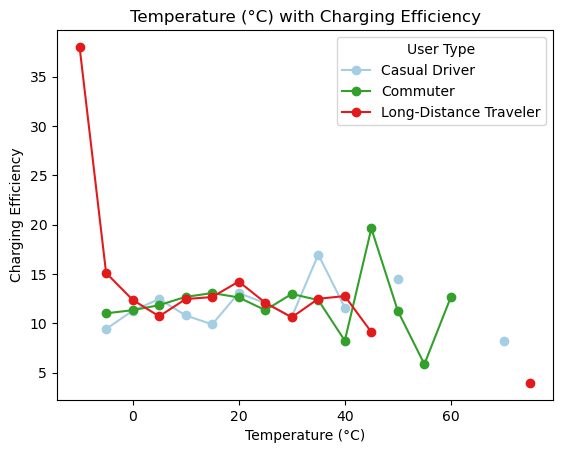

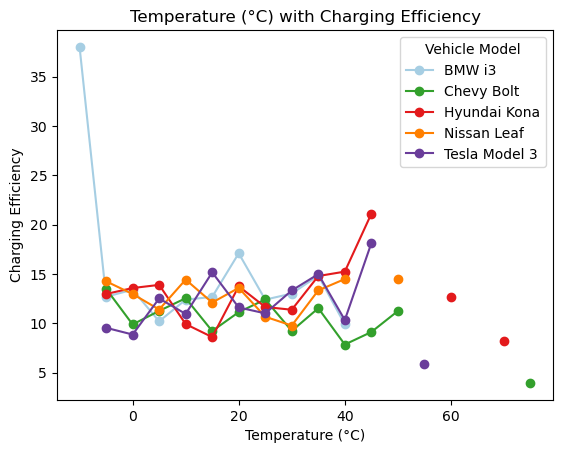

In [121]:
draw_plot_by("Temperature (°C)", "Temperature with user type", "Charging Efficiency", "User Type", -20, 100, 5, "upper right")
draw_plot_by("Temperature (°C)", "Temperature with Vehicle Model", "Charging Efficiency", "Vehicle Model", -20, 100, 5, "upper right")

C:\Users\hsing\AppData\Local\Temp\ipykernel_5756\1946816722.py:9: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(data[X], data[Y], c=color[i], label= unique_categories.iloc[i, 0])


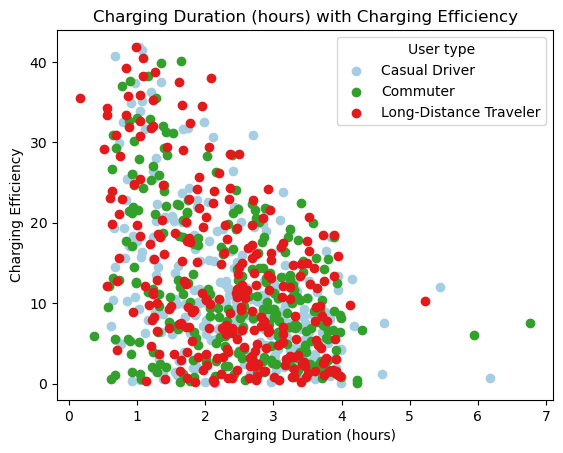

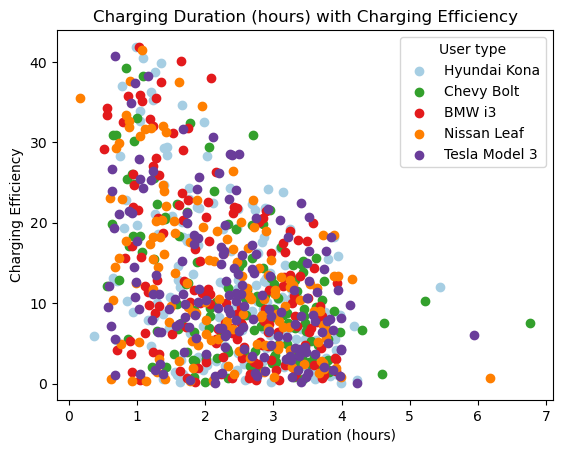

In [122]:

def draw_scatter(X, Y, label):
    unique_categories = df[[label]].drop_duplicates()
    color_name = "Paired"
    select = (0, 3, 5, 7, 9)
    color = plt.get_cmap(color_name)(select)

    for i in range(0, len(unique_categories)):
        data = df[(df[label] == unique_categories.iloc[i, 0])]
        plt.scatter(data[X], data[Y], c=color[i], label= unique_categories.iloc[i, 0])
    plt.legend(title="User type", loc="upper right")
    plt.xlabel(X)
    plt.ylabel(Y)
    plt.title(X+" with "+Y)
    plt.show()

list = ['Charging Duration (hours)', 'Time of Day', 'State of Charge (Start %)', 'State of Charge (End %)', 'Temperature (°C)', 'Vehicle Age (years)']
list2 = ["User Type", "Vehicle Model"]

def draw_many(row, column, Y, list, list2):
    color_name = "Paired"
    select = (0, 3, 5, 7, 9)
    color = plt.get_cmap(color_name)(select)
    fig, axes = plt.subplots(row, column, figsize=(10, 8))

    numbers = []
    for i in range(0, len(list)):
        for t in range(0, len(list2)):
            numbers.append((list[i], list2[t]))

    index = 0

    for row in range(0, row):
        for column in range(0, column):
            unique_categories = df[[label]].drop_duplicates()


            for i in range(0, len(unique_categories)):
                data = df[(df[numbers[1]] == unique_categories.iloc[i, 0])]
                axes[row, column].scatter(data[numbers[index][0]], data[Y], c=color[i], label= unique_categories.iloc[i, 0])
            axes[row, column].legend(title="User type", loc="upper right")
            axes[row, column].xlabel(numbers[index][0])
            axes[row, column].ylabel(Y)
            axes[row, column].title(numbers[index][0] +" with "+Y)
            index += 1

    fig.tight_layout()
    plt.show()

list = ['Charging Duration (hours)', 'Time of Day', 'State of Charge (Start %)', 'State of Charge (End %)', 'Temperature (°C)', 'Vehicle Age (years)']
list2 = ["User Type", "Vehicle Model"]
for row in list:
    for label in list2:
        draw_scatter(row, "Charging Efficiency", label)
    break
# draw_many(3,4, "Charging Efficiency", list, list2)

Random Forest Regressor R^2 Score: 0.7690440978940608
Random Forest Regressor RMSE: 4.468571794120687


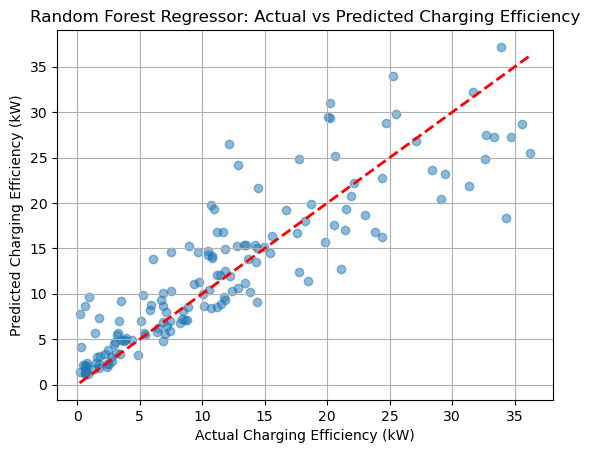

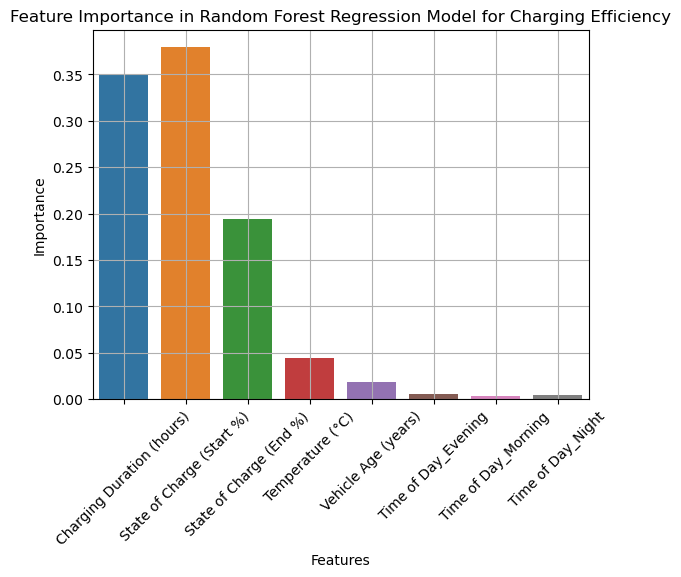

In [123]:
# Select features and target variables 选择特征和目标变量
features = ['Charging Duration (hours)', 'Time of Day', 'State of Charge (Start %)', 'State of Charge (End %)', 'Temperature (°C)', 'Vehicle Age (years)']
X = pd.get_dummies(df[features], drop_first=True)
y = df['Charging Efficiency']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

# Random Forest
rf_regressor = RandomForestRegressor(n_estimators=100, random_state=1)
rf_regressor.fit(X_train, y_train)
y_pred_rf = rf_regressor.predict(X_test)

# Evaluate Random Forest model performance 评估随机森林模型性能
print("Random Forest Regressor R^2 Score:", r2_score(y_test, y_pred_rf))
print("Random Forest Regressor RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_rf)))

# Visualize the regression results 可视化回归结果
plt.scatter(y_test, y_pred_rf, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', linewidth=2)
plt.xlabel('Actual Charging Efficiency (kW)')
plt.ylabel('Predicted Charging Efficiency (kW)')
plt.title('Random Forest Regressor: Actual vs Predicted Charging Efficiency')
plt.grid(True)
plt.show()

# Feature Importance Analysis for Charging Efficiency Regression 充电效率回归的特征重要性分析
feature_importances = rf_regressor.feature_importances_
sns.barplot(x=X.columns, y=feature_importances)
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Feature Importance in Random Forest Regression Model for Charging Efficiency')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()



c:\Users\hsing\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\hsing\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(
c:\Users\hsing\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\hsing\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are

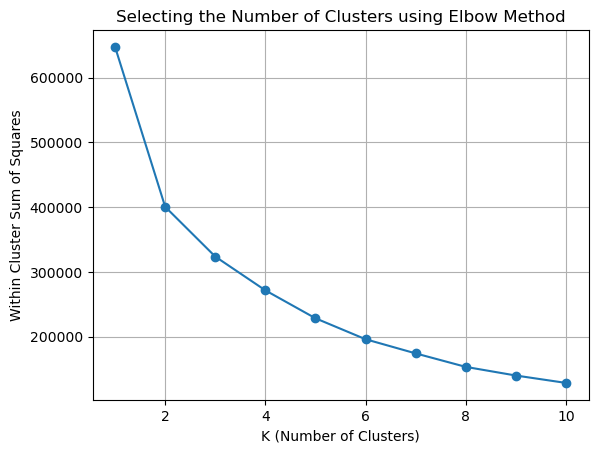

c:\Users\hsing\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\hsing\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(
c:\Users\hsing\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\hsing\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are

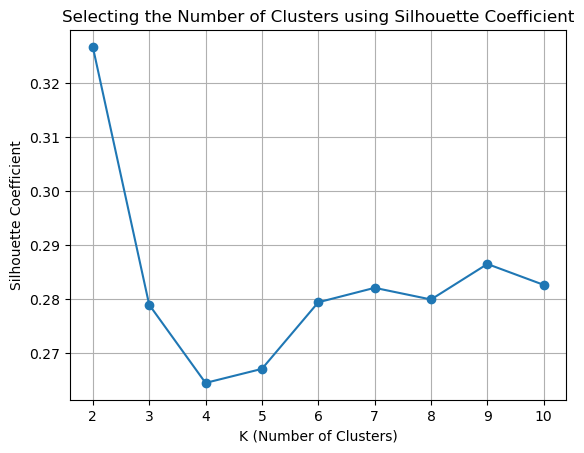

In [124]:
# Elbow Method
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, random_state=1)
    kmeans.fit(X)
    wcss.append(kmeans.inertia_)

plt.plot(range(1, 11), wcss, marker='o')
plt.xlabel('K (Number of Clusters)')
plt.ylabel('Within Cluster Sum of Squares')
plt.title('Selecting the Number of Clusters using Elbow Method')
plt.grid(True)
plt.show()

# Silhouette Coefficient
silhouette_scores = []
for i in range(2, 11):
    kmeans = KMeans(n_clusters=i, random_state=1)
    labels = kmeans.fit_predict(X)
    silhouette_scores.append(silhouette_score(X, labels))

plt.plot(range(2, 11), silhouette_scores, marker = 'o')
plt.xlabel('K (Number of Clusters)')
plt.ylabel('Silhouette Coefficient')
plt.title('Selecting the Number of Clusters using Silhouette Coefficient')
plt.grid(True)
plt.show()


c:\Users\hsing\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\hsing\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


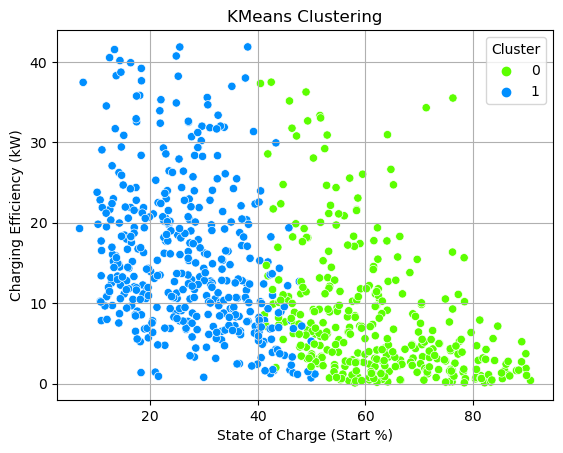

In [125]:
# KMeans
kmeans = KMeans(n_clusters=2, random_state=1)
df['Cluster'] = kmeans.fit_predict(X)

sns.scatterplot(x=df['State of Charge (Start %)'], y=df['Charging Efficiency'], hue=df['Cluster'], palette='gist_rainbow')
plt.xlabel('State of Charge (Start %)')
plt.ylabel('Charging Efficiency (kW)')
plt.title('KMeans Clustering')
plt.grid(True)
plt.show()
